# Chunking with HDF5

For this exercise you will create multiple datasets inside of a HDF5 file. Datasets will be created using multiple configurations and chunking schemes. You will measure creation time for the datasets, size of the datasets, and reading time from the datasets. Finally, you will display plots comparing different measurements and you will provide explanations that justify the measurements.

## HDF5 file structure

You will create a group named `chunks`. Inside the group `chunks`, create the groups `trivial`, `random`, `norm`, `norm2`. Inside every group you have just created, you will create the datasets `contiguous`, `chunked`, `gzip`, `lzf`, `shuffle`, `checksum`, `1000x1` and `1x1000`. The HDF5 will have then the following structure:

```
chunks
chunks/norm
chunks/norm/1000x1
chunks/norm/1x1000
chunks/norm/checksum
chunks/norm/chunked
chunks/norm/contiguous
chunks/norm/gzip
chunks/norm/lzf
chunks/norm/shuffle
chunks/norm2
chunks/norm2/1000x1
chunks/norm2/1x1000
chunks/norm2/checksum
chunks/norm2/chunked
chunks/norm2/contiguous
chunks/norm2/gzip
chunks/norm2/lzf
chunks/norm2/shuffle
chunks/random
chunks/random/1000x1
chunks/random/1x1000
chunks/random/checksum
chunks/random/chunked
chunks/random/contiguous
chunks/random/gzip
chunks/random/lzf
chunks/random/shuffle
chunks/trivial
chunks/trivial/1000x1
chunks/trivial/1x1000
chunks/trivial/checksum
chunks/trivial/chunked
chunks/trivial/contiguous
chunks/trivial/gzip
chunks/trivial/lzf
chunks/trivial/shuffle
```

The datasets will have the following properties:

- `contiguous` - Contiguous storage, shape=(1000, 1000), dtype="f8".
- `chunked` - Chunked storage with chunk sizes determined by HDF5, shape=(1000, 1000), dtype="f8".
- `gzip` - Chunked storage with chunk sizes determined by HDF5, gzip compression, shape=(1000, 1000), dtype="f8".
- `lzf` - Chunked storage with chunk sizes determined by HDF5, lzf compression, shape=(1000, 1000), dtype="f8".
- `shuffle` - Chunked storage with chunk sizes determined by HDF5, gzip compression, shape=(1000, 1000), dtype="f8", SHUFFLE filter enabled.
- `checksum` - Chunked storage with chunk sizes determined by HDF5, gzip compression, shape=(1000, 1000), dtype="f8", SHUFFLE filter enabled, FLETCHER32 filter enabled.
- `1000x1` - Chunked storage with chunk sizes (1000,1), gzip compression, shape=(1000, 1000), dtype="f8", SHUFFLE filter enabled, FLETCHER32 filter enabled.
- `1x1000` - Chunked storage with chunk sizes (1,1000), gzip compression, shape=(1000, 1000), dtype="f8", SHUFFLE filter enabled, FLETCHER32 filter enabled.

## Filling the datasets with numerical data

The datasets in the `trivial` group will be filled with trivial data, hence the name, generated with:

```python
np.arange(10**6, dtype="f8").reshape((1000,1000)
```

The datasets in the `random` group will be filled with random data, generated with:

```python
np.random.random((1000,1000)
```

The datasets in the `norm` group will be filled with random gaussian data, generated with:

```python
np.random.normal(270, 10, (1000,1000))
```

The datasets in the `norm2` group will be filled with random gaussian data truncated to 2 decimals, generated with:

```python
np.random.normal(270, 10, (1000,1000)).round(2)
```

## Time and size measures

You will measure three parameters:

- Writing time.
- Reading time. You will test the following pattern: `[::20,:].mean(axis=1)`. Study reading time only for the `checksum`, `1x1000` and `1000x1` datasets.
- Dataset size.

Writing time and dataset size will be measured while filling the dataset with the numerical data. Reading time will be measured afterwards.

For measuring reading and writing times, you can use the `time` module to store the current time before and after reading and writing as follows:

```python
import time

start = time.time()
dataset[:] = ...
h5file.flush() # force buffers to write to disk
end = time.time()

ellapsed_time = end - start # in milliseconds
```

For measuring file size, you can use the `os` module to record the HDF5 file size before and after filling the dataset:

```python
import os

size1 = os.stat(h5file.filename).st_size
dataset[:] = ...
h5file.flush() # force buffers to write to disk
size2 = os.stat(h5file.filename).st_size

dataset_size = size2 - size1 # in bytes
```

## Using plots to compare measurements

Create a table with the following structure in order to record measurements:

|    | group   | dset       |      wtime |      rtime |    size |
|---:|:--------|:-----------|-----------:|-----------:|--------:|
|  0 | trivial | contiguous | 0.00855637 | 0.00294065 | 8000000 |
|  1 | trivial | chunked    | 0.0117407  | 0.0170555  | 8144208 |
|  2 | trivial | gzip       | 0.091738   | 0.0291584  | 1400260 |
|  3 | trivial | lzf        | 0.0173485  | 0.0180824  | 4033665 |
|  4 | trivial | shuffle    | 0.0621376  | 0.03249    |  223525 |
|  5 | trivial | checksum   | 0.0537057  | 0.0328758  |  224549 |
|  6 | trivial | 1000x1     | 0.0976098  | 0.0224636  | 1341913 |
|  7 | trivial | 1x1000     | 0.0531054  | 0.0469017  |  263174 |
| ...| ...     | ...        | ...        | ...        | ...     |

Load the results into a Pandas DataFrame and plot three bar plots for each variable. Answer the following questions:

1. - Explain the differences in file sizes between the groups `trivial` and `random`.
2. - Explain the differences in file sizes between the groups `norm` and `norm2`.
3. - Explain the differences in writing time depending on the configuration of the dataset.
4. - Do you appreciate any difference in reading times for the given pattern? Which is the cause of these differences?
5. - In your opinion, do you think that compression justifies more CPU time in exchange of less file size?

In [1]:
import os
import time
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
fname = "chunks.h5"
shape = (1000, 1000)
groups = ("trivial", "random", "norm", "norm2")
dsets = ("contiguous", "chunked", "gzip", "lzf", "shuffle", "checksum", "1000x1", "1x1000")

In [4]:
arrsize = len(groups) * len(dsets)
wtime = np.zeros(arrsize)
size = np.zeros(arrsize)
rtime = np.zeros(arrsize)

En primer lugar, creamos el fichero HDF5, midiendo las variables `wtime` y `size`:

In [5]:
n = len(dsets)
with h5py.File(fname, "w") as f:
    chunks = f.create_group("chunks")
    for i, g in enumerate(groups):
        grp = chunks.create_group(g)
        
        # trivial
        if g == groups[0]:
            arr = np.arange(10**6, dtype="f8").reshape((1000,1000))
            
            for j, ds in enumerate(dsets):
                # contiguous
                if ds == dsets[0]:
                    d = grp.create_dataset(ds, shape, dtype = 'f8')
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # chunked
                if ds == dsets[1]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # gzip
                if ds == dsets[2]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True, compression = "gzip")
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # lzf
                if ds == dsets[3]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True, compression = "lzf")
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # shuffle
                if ds == dsets[4]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True, compression="gzip", shuffle=True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # checksum
                if ds == dsets[5]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True, compression="gzip", shuffle= True, fletcher32= True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # 1000x1
                if ds == dsets[6]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = (1000,1), compression="gzip", shuffle= True, fletcher32= True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                
                # 1x1000                       
                if ds == dsets[7]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = (1, 1000), compression="gzip", shuffle= True, fletcher32= True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
        # random     
        if g == groups[1]:                                               
            arr = np.random.random(shape)
            
            for j, ds in enumerate(dsets):
                # contiguous
                if ds == dsets[0]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8')
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # chunked
                if ds == dsets[1]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # gzip
                if ds == dsets[2]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True, compression = "gzip")
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # lzf
                if ds == dsets[3]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True, compression = "lzf")
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # shuffle
                if ds == dsets[4]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True, compression="gzip", shuffle=True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # checksum
                if ds == dsets[5]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True, compression="gzip", shuffle= True, fletcher32= True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # 1000x1
                if ds == dsets[6]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = (1000,1), compression="gzip", shuffle= True, fletcher32= True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                
                # 1x1000                       
                if ds == dsets[7]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = (1, 1000), compression="gzip", shuffle= True, fletcher32= True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
        # norm     
        if g == groups[2]:                                               
            arr = np.random.normal(270, 10, shape)
            
            for j, ds in enumerate(dsets):
                # contiguous
                if ds == dsets[0]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8')
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # chunked
                if ds == dsets[1]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # gzip
                if ds == dsets[2]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True, compression = "gzip")
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # lzf
                if ds == dsets[3]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True, compression = "lzf")
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # shuffle
                if ds == dsets[4]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True, compression="gzip", shuffle=True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # checksum
                if ds == dsets[5]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True, compression="gzip", shuffle= True, fletcher32= True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # 1000x1
                if ds == dsets[6]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = (1000,1), compression="gzip", shuffle= True, fletcher32= True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                
                # 1x1000                       
                if ds == dsets[7]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = (1, 1000), compression="gzip", shuffle= True, fletcher32= True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1

        # norm2
        if g == groups[3]:                                               
            arr = np.random.normal(270, 10, shape).round(2)
            
            for j, ds in enumerate(dsets):
                # contiguous
                if ds == dsets[0]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8')
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # chunked
                if ds == dsets[1]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # gzip
                if ds == dsets[2]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True, compression = "gzip")
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # lzf
                if ds == dsets[3]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True, compression = "lzf")
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # shuffle
                if ds == dsets[4]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True, compression="gzip", shuffle=True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # checksum
                if ds == dsets[5]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = True, compression="gzip", shuffle= True, fletcher32= True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                    
                # 1000x1
                if ds == dsets[6]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = (1000,1), compression="gzip", shuffle= True, fletcher32= True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1
                
                # 1x1000                       
                if ds == dsets[7]: 
                    d = grp.create_dataset(ds, shape, dtype = 'f8', chunks = (1, 1000), compression="gzip", shuffle= True, fletcher32= True)
                    start = time.perf_counter()
                    size1 = os.stat(f.filename).st_size
                    d[...] = arr
                    f.flush()                  
                    end = time.perf_counter()
                    size2 = os.stat(f.filename).st_size
                    wtime[i*n+j] = end - start
                    size[i*n+j] = size2 - size1


In [6]:
!h5dump -n chunks.h5

HDF5 "chunks.h5" {
FILE_CONTENTS {
 group      /
 group      /chunks
 group      /chunks/norm
 dataset    /chunks/norm/1000x1
 dataset    /chunks/norm/1x1000
 dataset    /chunks/norm/checksum
 dataset    /chunks/norm/chunked
 dataset    /chunks/norm/contiguous
 dataset    /chunks/norm/gzip
 dataset    /chunks/norm/lzf
 dataset    /chunks/norm/shuffle
 group      /chunks/norm2
 dataset    /chunks/norm2/1000x1
 dataset    /chunks/norm2/1x1000
 dataset    /chunks/norm2/checksum
 dataset    /chunks/norm2/chunked
 dataset    /chunks/norm2/contiguous
 dataset    /chunks/norm2/gzip
 dataset    /chunks/norm2/lzf
 dataset    /chunks/norm2/shuffle
 group      /chunks/random
 dataset    /chunks/random/1000x1
 dataset    /chunks/random/1x1000
 dataset    /chunks/random/checksum
 dataset    /chunks/random/chunked
 dataset    /chunks/random/contiguous
 dataset    /chunks/random/gzip
 dataset    /chunks/random/lzf
 dataset    /chunks/random/shuffle
 group      /chunks/trivial
 dataset    /chunks/triv

Leemos los datos para calcular `rtime`:

In [7]:
rdsets = ("checksum", "1000x1", "1x1000")
n = len(dsets)
with h5py.File(fname, "r") as f:
    chunks = f["chunks"]
    for i, g in enumerate(groups):
        grp = chunks[g]
        for j, ds in enumerate(dsets):
            if ds in rdsets:
                start = time.perf_counter()
                arr = grp[ds][::20,:].mean(axis=1)                  
                end = time.perf_counter()
                rtime[i*n+j] = end - start

Ploteamos los diagramas de barras, utilizando un dataset de `Pandas`:

<IPython.core.display.Javascript object>


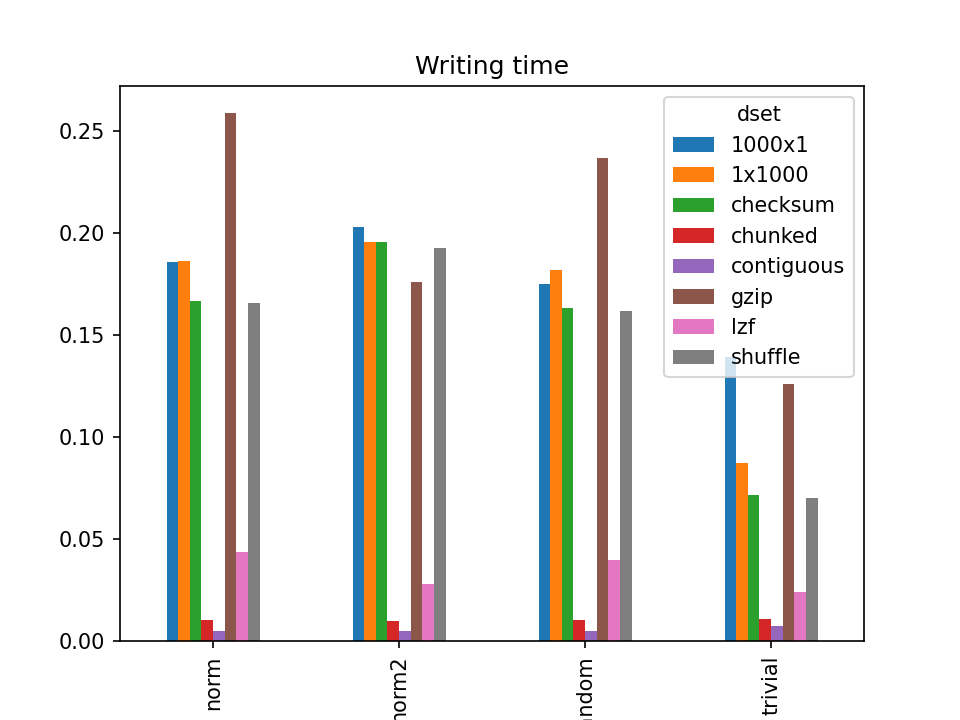

<IPython.core.display.Javascript object>


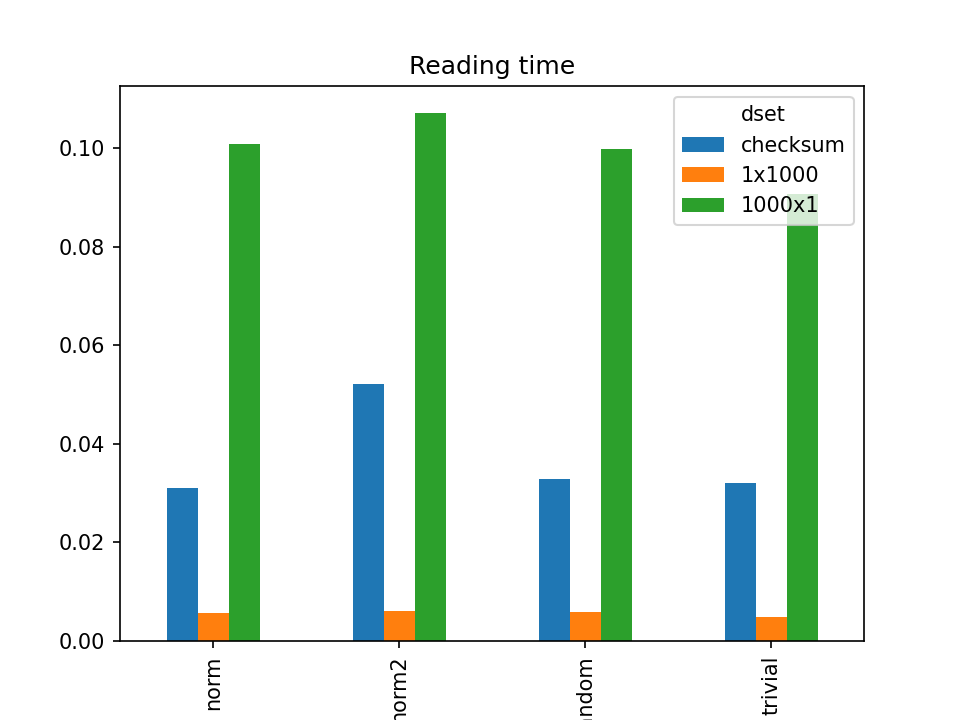

<IPython.core.display.Javascript object>


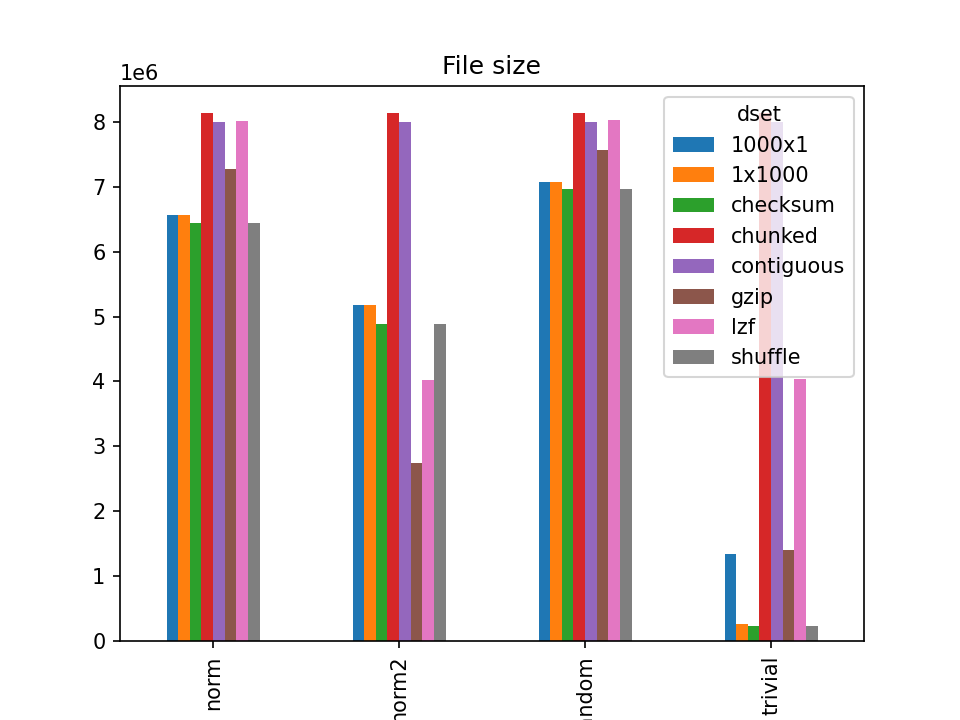

<AxesSubplot:title={'center':'File size'}, xlabel='group'>

In [9]:
df = pd.DataFrame(data, columns=['group', 'dset', 'wtime', 'rtime', 'size']).set_index(['group', 'dset'])
df['wtime'].unstack().plot.bar(title='Writing time')
df.loc[(slice(None), ['checksum', '1x1000', '1000x1']), 'rtime'].unstack().plot.bar(title='Reading time')
df['size'].unstack().plot.bar(title='File size')

## Conclusiones

#### 1. Explicar la diferencia entre el tamaño de archivo para los grupos `trivial` y `random`:
Se aprecia como para los datos que no están comprimidos, `contiguous` y `chunked`, el tamaño de archivo es similar en `trivial` y `random`. Sin embargo, los datos comprimidos ocupan una cantidad significativamente menor de espacio cuando son `trivial`. Esto puede deberse a que los algoritmos de compresión son mucho más efectivos con este tipo de datos en concreto, ya que al provenir de un `arange()` están ordenados y resultan más accesibles desde el punto de vista de la compresión.

#### 2. Explicar la diferencia entre el tamaño de archivo para los grupos `norm` y `norm2`:
Nuevamente, no se aprecian diferencias para los datos sin comprimir. Para los comprimidos, vemos que ocupan menos espacio cuando son `norm2`. Esto se debe a que son datos más simples, lo que permite una mejor compresión, sobretodo cuando se utiliza `gzip`.

#### 3. Explicar la diferencia en el tiempo de escritura según la configuración del dataset:
En general, se observan tendencias similares entre los tipos de datos. Para los datos sin comprimir, el tiempo de escritura es minúsculo en comparación con el resto de datos, ya que no se está utilizando ningún algoritmo de compresión, lo que añade tiempo de computación. Además, el tiempo de escritura es menor para `contiguous`, ya que al tener una organización por chunks, los datos se escriben linealmente en memoria, ahorrando tiempo. 

Por otro lado, se obtienen varias conclusiones sobre los datos comprimidos: 
* Para todos ellos el tiempo de escritura disminuye acorde a la complejidad de los datos, registrando los tiempos más rápidos para `trivial`.
* El algoritmo de compresión más rápido es, con diferencia, `lfz`, lo que era de esperar, ya que es un compresor característico por su velocidad.

#### 4. ¿Se aprecian diferencias en los tiempos de lectura? ¿A qué se deben?
El tiempo de lectura, que hemos medido para las variables `checksum`, `1x1000` y `1000x1`, depende enormemente de la forma en la que se estructuren los chunks de memoria, como se puede apreciar en la gráfica. Recordamos que lo que estamos leyendo es 

```python
arr = grp[ds][::20,:].mean(axis=1)
```
Es decir, estamos operando por filas. Por este motivo, el menor tiempo de lectura se da en los chunks de 1x1000, organizados por filas, haciendo que la lectura de los datos sea secuencial. Por otro lado, el tiempo aumenta para `checksum` ya que hemos dejado que HDF5 decida cuál es la forma de los chunks, de la que podemos deducir que no es óptima. Finalmente, el tiempo de lectura aumenta enormemente para los chunks de 1000x1. Esto se debe a que los datos se estan almacenando en memoria por columnas cuando estamos operando por filas, lo que provoca que para acceder a un dato de interés sea necesario recorrer 1000 datos inservibles, resultando en un proceso enormemente ineficaz.

#### 5. En tu opinión, ¿la compresión justifica más tiempo de CPU a cambio de un tamaño de archivo menor?
La compresión es un proceso importante ya que en la actualidad se manejan volúmenes inmensos de datos y el espacio para almacenarlos es limitado. Al comprimirlos, permitimos almacenar más datos en menos espacio, y lo único que se sacrifica es cierto coste computacional en términos de tiempo de CPU a la hora de escibirlos y de leerlos, lo que se traduce en el uso de algo más de tiempo y energía a la hora de acceder a los datos. Como en general los datos se ecriben una única vez y es posible que algunos ni siquiera lleguen a leerse, creo que está justificado comprimir los archivos como norma general.